LOADING LIBRARIES

In [2]:
import emoji
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk import pos_tag, ne_chunk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
from better_profanity import profanity
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
import torch
import torch.nn.functional as F
from transformers import pipeline
from sklearn.metrics import confusion_matrix
from wordcloud import WordCloud

LOADING DATA - COMMENTS OF SUPREME POSTS

In [10]:
#links from which comments were taken
"https://www.instagram.com/p/BPc7H-0BRSs/?taken-by=supremenewyork", #January 19, 2017
"https://www.instagram.com/p/BPc7UsMhxCd/?taken-by=supremenewyork" #January 19, 2017

'https://www.instagram.com/p/BPc7UsMhxCd/?taken-by=supremenewyork'

In [3]:
#loading excels, where comments were saved
post_1 = pd.read_excel("instagram-dior.xlsx")
post_2 = pd.read_excel("instagram-dior2.xlsx")

BASIC DATA PREPROCESSING AND MODELING

In [4]:
post_1 = post_1.iloc[:, 2:-1]
post_2 = post_2.iloc[:, 2:-1]

# Set the first row as the header
post_1.columns = post_1.iloc[0]
post_2.columns = post_2.iloc[0]

# Remove the first row after setting it as the header
post_1 = post_1[1:]
post_2 = post_2[1:]

post_comment_1 = post_1[['Date', 'Comment']]
post_comment_2 = post_2[['Date', 'Comment']]

In [5]:
print("Shape of post_comment_1:", post_comment_1.shape)
print("Shape of post_comment_2:", post_comment_2.shape)

Shape of post_comment_1: (2645, 2)
Shape of post_comment_2: (236, 2)


PLOTTING DATA

C:\Users\sofiia.vernydub\AppData\Local\Temp\ipykernel_39980\397006165.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  post_comment_1['DataFrame'] = 'post_comment_1'
C:\Users\sofiia.vernydub\AppData\Local\Temp\ipykernel_39980\397006165.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  post_comment_2['DataFrame'] = 'post_comment_2'


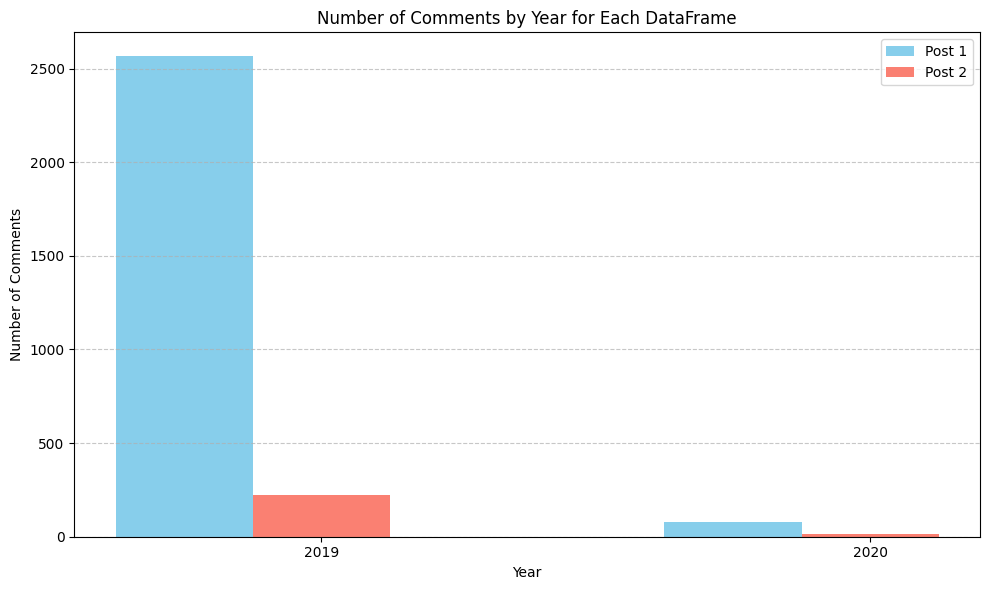

In [6]:
# Add a new column indicating the source DataFrame for each DataFrame
post_comment_1['DataFrame'] = 'post_comment_1'
post_comment_2['DataFrame'] = 'post_comment_2'


# Combine the DataFrames into a single DataFrame
all_comments_df = pd.concat([post_comment_1, post_comment_2])

# Convert 'Date' column to datetime type if not already done
all_comments_df['Date'] = pd.to_datetime(all_comments_df['Date'])

# Extract year from 'Date' column
all_comments_df['Year'] = all_comments_df['Date'].dt.year

# Get the unique years for all DataFrames
all_years = all_comments_df['Year'].unique()

# Count comments by year for each DataFrame
comment_counts_1 = all_comments_df[all_comments_df['DataFrame'] == 'post_comment_1']['Year'].value_counts().sort_index()
comment_counts_2 = all_comments_df[all_comments_df['DataFrame'] == 'post_comment_2']['Year'].value_counts().sort_index()
#comment_counts_3 = all_comments_df[all_comments_df['DataFrame'] == 'supreme_comment_3']['Year'].value_counts().sort_index()


# Count comments by year for each DataFrame
comment_counts_1 = all_comments_df[all_comments_df['DataFrame'] == 'post_comment_1']['Year'].value_counts().sort_index()
comment_counts_2 = all_comments_df[all_comments_df['DataFrame'] == 'post_comment_2']['Year'].value_counts().sort_index()
# Create a DataFrame with all comment counts and fill missing years with zeros
comment_counts_df = pd.DataFrame({'Post 1': comment_counts_1,
                                  'Post 2': comment_counts_2}, index=all_years).fillna(0)

# Plotting
plt.figure(figsize=(10, 6))

bar_width = 0.25
index = range(len(all_years))

plt.bar(index, comment_counts_df['Post 1'], color='skyblue', width=bar_width, label='Post 1')
plt.bar([i + bar_width for i in index], comment_counts_df['Post 2'], color='salmon', width=bar_width, label='Post 2')

plt.xlabel('Year')
plt.ylabel('Number of Comments')
plt.title('Number of Comments by Year for Each DataFrame')
plt.xticks([i + bar_width for i in index], all_years)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


APPENDING DATA

In [7]:
all_post_comments_df = pd.concat([post_comment_1, post_comment_2], ignore_index=True)
all_post_comments_df.reset_index(inplace=True)
all_post_comments_df['Date'] = pd.to_datetime(all_post_comments_df['Date'])
all_post_comments_df['Date'] = all_post_comments_df['Date'].dt.strftime('%d-%m-%Y')
all_post_comments_df.drop(columns=['DataFrame', 'index'], inplace=True)

In [8]:
all_post_comments_df[:5]

,Date,Comment
0,05-12-2019,😍😍
1,05-12-2019,🔥Fire
2,05-12-2019,🔥🔥🔥🔥
3,05-12-2019,Where can you purchase them?
4,05-12-2019,🖤🖤🖤🖤🖤


DATA PREPROCESING - PREPAIRING COMMENTS FOR SENTIMENT ANALYSIS

In [9]:
# Removing usernames from each comments, usernames start with @
def remove_usernames(comment):
    return re.sub(r'@\w+(\.\w+)*\s*', '', comment)
all_post_comments_df['Cleaned Comment'] = all_post_comments_df['Comment'].astype(str)
all_post_comments_df['Cleaned Comment'] = all_post_comments_df['Cleaned Comment'].apply(remove_usernames)

# Define a function to remove URLs
def remove_urls(comment):
    return re.sub(r'http\S+', '', comment)
all_post_comments_df['Cleaned Comment'] = all_post_comments_df['Cleaned Comment'].apply(remove_urls)

# Convert text to lowercase
all_post_comments_df['Cleaned Comment'] = all_post_comments_df['Cleaned Comment'].str.lower()

# Remove punctuation marks
all_post_comments_df['Cleaned Comment'] = all_post_comments_df['Cleaned Comment'].str.replace('[^\w\s]', '')

# Removing empty and whitespace-only rows
all_post_comments_df['Cleaned Comment'] = all_post_comments_df['Cleaned Comment'].str.strip()  # Remove leading and trailing whitespaces
all_post_comments_df = all_post_comments_df.dropna(subset=['Cleaned Comment'])  # Drop NaN values
all_post_comments_df = all_post_comments_df[all_post_comments_df['Cleaned Comment'] != '']  # Remove empty strings
all_post_comments_df.reset_index(drop=True, inplace=True)

profanity

In [10]:
def censored_profanity(comment):
    return profanity.censor(comment)
all_post_comments_df['Cleaned Comment'] = all_post_comments_df['Cleaned Comment'].apply(censored_profanity)

In [11]:
all_post_comments_df[:30]

,Date,Comment,Cleaned Comment
0,05-12-2019,😍😍,😍😍
1,05-12-2019,🔥Fire,🔥fire
2,05-12-2019,🔥🔥🔥🔥,🔥🔥🔥🔥
3,05-12-2019,Where can you purchase them?,where can you purchase them?
4,05-12-2019,🖤🖤🖤🖤🖤,🖤🖤🖤🖤🖤
5,05-12-2019,Want!!!! ☑️💣,want!!!! ☑️💣
6,05-12-2019,#DIOR #KimJones #MrKimJones #DiorByKimJones #J...,#dior #kimjones #mrkimjones #diorbykimjones #j...
7,05-12-2019,Ifb,ifb
8,05-12-2019,@why_no_forever 이고 이뿌지?,이고 이뿌지?
9,05-12-2019,Yang kurus Jangan liat profil aku nanti kamu g...,yang kurus jangan liat profil aku nanti kamu g...


MODEL 1 - j-hartmann/sentiment-roberta

In [12]:
# Load model
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
tokenizer = AutoTokenizer.from_pretrained("j-hartmann/sentiment-roberta-large-english-3-classes")
model = AutoModelForSequenceClassification.from_pretrained("j-hartmann/sentiment-roberta-large-english-3-classes")

# Load sentiment analysis pipeline
sentiment_analysis = pipeline("text-classification", model=model, tokenizer=tokenizer)

def analyze_sentiment(comment):
    sentiment = sentiment_analysis(comment)[0]
    return sentiment['label'], sentiment['score']

# Apply sentiment analysis to each comment in the DataFrame
all_post_comments_df['Sentiment.Model 1'], all_post_comments_df['Confidence Score.Model 1'] = zip(*all_post_comments_df['Cleaned Comment'].map(analyze_sentiment))

# Print the DataFrame with sentiment analysis results
all_post_comments_df[:10]


Some weights of the model checkpoint at j-hartmann/sentiment-roberta-large-english-3-classes were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


,Date,Comment,Cleaned Comment,Sentiment.Model 1,Confidence Score.Model 1
0,05-12-2019,😍😍,😍😍,positive,0.999673
1,05-12-2019,🔥Fire,🔥fire,positive,0.999453
2,05-12-2019,🔥🔥🔥🔥,🔥🔥🔥🔥,positive,0.999662
3,05-12-2019,Where can you purchase them?,where can you purchase them?,neutral,0.999241
4,05-12-2019,🖤🖤🖤🖤🖤,🖤🖤🖤🖤🖤,positive,0.999072
5,05-12-2019,Want!!!! ☑️💣,want!!!! ☑️💣,positive,0.999547
6,05-12-2019,#DIOR #KimJones #MrKimJones #DiorByKimJones #J...,#dior #kimjones #mrkimjones #diorbykimjones #j...,neutral,0.998258
7,05-12-2019,Ifb,ifb,neutral,0.998250
8,05-12-2019,@why_no_forever 이고 이뿌지?,이고 이뿌지?,neutral,0.998437
9,05-12-2019,Yang kurus Jangan liat profil aku nanti kamu g...,yang kurus jangan liat profil aku nanti kamu g...,positive,0.867524


In [13]:
# Calculate sentiment score for each label
label_sentiment_score_model_2 = all_post_comments_df.groupby('Sentiment.Model 1')['Confidence Score.Model 1'].mean()

print("Sentiment Scores for Model 1 - j-hartmann/sentiment-roberta")
print(label_sentiment_score_model_2)

Sentiment Scores for Model 1 - j-hartmann/sentiment-roberta
Sentiment.Model 1
negative    0.956416
neutral     0.964287
positive    0.986433
Name: Confidence Score.Model 1, dtype: float64


In [14]:
# Calculate sentiment labels
label_sentiment_count_model_2 = all_post_comments_df.groupby('Sentiment.Model 1')['Cleaned Comment'].count()

print("Sentiment Scores of Model 1 - j-hartmann/sentiment-roberta:")
print(label_sentiment_count_model_2)

Sentiment Scores of Model 1 - j-hartmann/sentiment-roberta:
Sentiment.Model 1
negative     306
neutral      575
positive    1435
Name: Cleaned Comment, dtype: int64


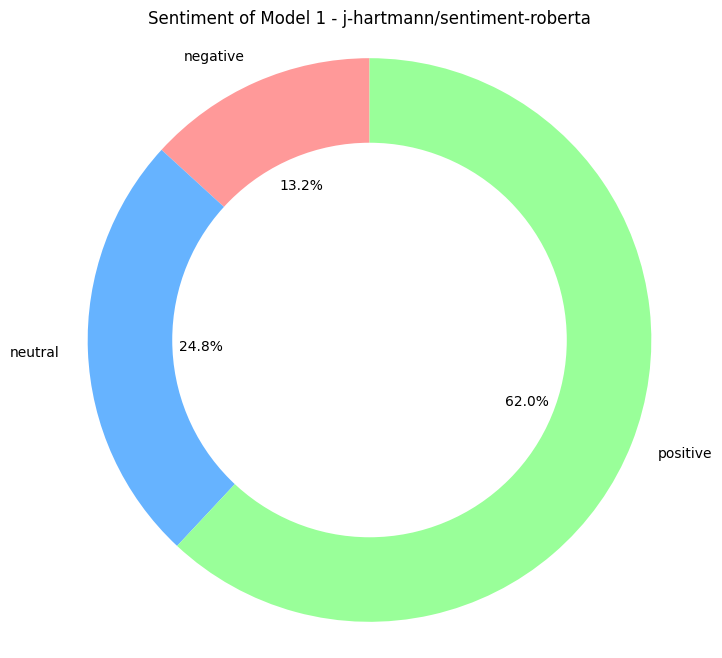

In [15]:
# Grouping the data by 'Sentiment.Label.Model 1' and counting the occurrences
label_sentiment_count_model_1 = all_post_comments_df.groupby('Sentiment.Model 1')['Cleaned Comment'].count()

# Plotting the donut chart
plt.figure(figsize=(8, 8))
plt.pie(label_sentiment_count_model_1, labels=label_sentiment_count_model_1.index, autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff','#99ff99'])
plt.title("Sentiment of Model 1 - j-hartmann/sentiment-roberta")
plt.gca().add_artist(plt.Circle((0,0),0.70,fc='white')) # Donut chart
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

Model 2 - cardiffnlp/twitter-roberta-base-sentiment-latest

In [16]:
#Labels: 0 -> Negative; 1 -> Neutral; 2 -> Positive

# Load model 
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")
# Create a sentiment analysis pipeline
pipe = pipeline("text-classification", model=model, tokenizer=tokenizer)

# Assuming your DataFrame is named all_post_comments_df and contains a 'Comment' column
all_post_comments_df['Sentiment.Model 2'] = ""
all_post_comments_df['Confidence Score.Model 2'] = ""

# Iterate over each comment in the DataFrame and perform sentiment analysis
for index, row in all_post_comments_df.iterrows():
    comment = row['Cleaned Comment']
    result = pipe(comment)
    all_post_comments_df.at[index, 'Sentiment.Model 2'] = result[0]['label']
    all_post_comments_df.at[index, 'Confidence Score.Model 2'] = result[0]['score']

# Define a function to map sentiment labels to categories
def map_sentiment_label(sentiment_label):
    if sentiment_label == 'LABEL_0':
        return 'Negative'
    elif sentiment_label == 'LABEL_1':
        return 'Neutral'
    elif sentiment_label == 'LABEL_2':
        return 'Positive'
    else:
        return 'Unknown'

all_post_comments_df[:10]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


,Date,Comment,Cleaned Comment,Sentiment.Model 1,Confidence Score.Model 1,Sentiment.Model 2,Confidence Score.Model 2
0,05-12-2019,😍😍,😍😍,positive,0.999673,positive,0.947813
1,05-12-2019,🔥Fire,🔥fire,positive,0.999453,positive,0.545375
2,05-12-2019,🔥🔥🔥🔥,🔥🔥🔥🔥,positive,0.999662,positive,0.906876
3,05-12-2019,Where can you purchase them?,where can you purchase them?,neutral,0.999241,neutral,0.944432
4,05-12-2019,🖤🖤🖤🖤🖤,🖤🖤🖤🖤🖤,positive,0.999072,positive,0.938763
5,05-12-2019,Want!!!! ☑️💣,want!!!! ☑️💣,positive,0.999547,neutral,0.544228
6,05-12-2019,#DIOR #KimJones #MrKimJones #DiorByKimJones #J...,#dior #kimjones #mrkimjones #diorbykimjones #j...,neutral,0.998258,neutral,0.843158
7,05-12-2019,Ifb,ifb,neutral,0.998250,neutral,0.482623
8,05-12-2019,@why_no_forever 이고 이뿌지?,이고 이뿌지?,neutral,0.998437,neutral,0.806604
9,05-12-2019,Yang kurus Jangan liat profil aku nanti kamu g...,yang kurus jangan liat profil aku nanti kamu g...,positive,0.867524,positive,0.871454


In [17]:
label_sentiment_count_model_2= all_post_comments_df.groupby('Sentiment.Model 2')['Cleaned Comment'].count()

print("Sentiment Scores of Model 2 - cardiffnlp/twitter-roberta-base-sentiment-latest:")
print(label_sentiment_count_model_2)

Sentiment Scores of Model 2 - cardiffnlp/twitter-roberta-base-sentiment-latest:
Sentiment.Model 2
negative      94
neutral      858
positive    1364
Name: Cleaned Comment, dtype: int64


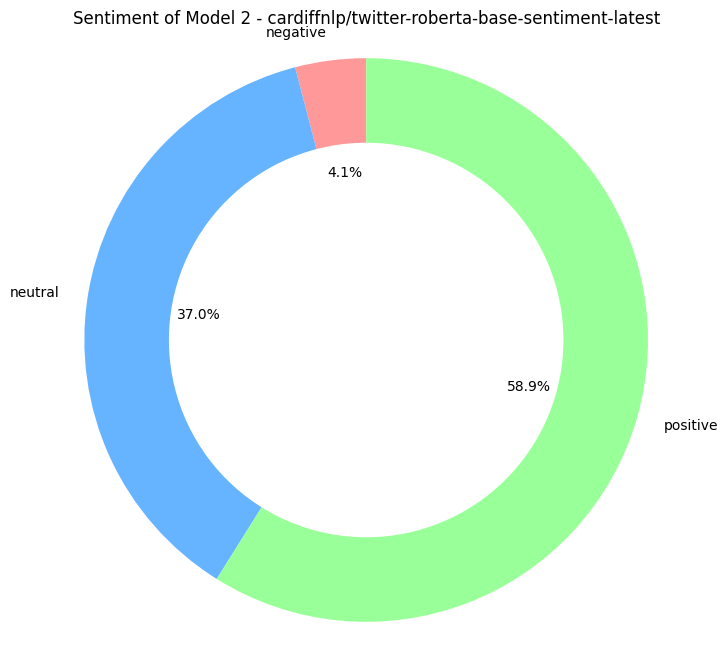

In [18]:
# Grouping the data by 'Sentiment.Label.Model 1' and counting the occurrences
label_sentiment_count_model_2 = all_post_comments_df.groupby('Sentiment.Model 2')['Cleaned Comment'].count()

# Plotting the donut chart
plt.figure(figsize=(8, 8))
plt.pie(label_sentiment_count_model_2, labels=label_sentiment_count_model_2.index, autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff','#99ff99'])
plt.title("Sentiment of Model 2 - cardiffnlp/twitter-roberta-base-sentiment-latest")
plt.gca().add_artist(plt.Circle((0,0),0.70,fc='white')) # Donut chart
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [19]:
# Compare predictions of Sentiment.Label.Model 1 and Sentiment.Label.Model 2
all_post_comments_df['Prediction_Match'] = all_post_comments_df['Sentiment.Model 1'] == all_post_comments_df['Sentiment.Model 2']

# Filter rows where predictions do not match
mismatched_predictions = all_post_comments_df[~all_post_comments_df['Prediction_Match']]

# Count the number of mismatched predictions
mismatch_count = len(mismatched_predictions)

# Set the maximum number of rows to display
pd.set_option('display.max_rows', None)

# Display rows where predictions do not match
print("Cases where predictions of Sentiment.Label.Model 1 and Sentiment.Label.Model 2 do not match:")
print("Number of mismatched predictions:", mismatch_count)
mismatched_predictions[:10]


Cases where predictions of Sentiment.Label.Model 1 and Sentiment.Label.Model 2 do not match:
Number of mismatched predictions: 490


,Date,Comment,Cleaned Comment,Sentiment.Model 1,Confidence Score.Model 1,Sentiment.Model 2,Confidence Score.Model 2,Prediction_Match
5,05-12-2019,Want!!!! ☑️💣,want!!!! ☑️💣,positive,0.999547,neutral,0.544228,False
15,05-12-2019,Ahh⚡💸,ahh⚡💸,positive,0.992364,neutral,0.59741,False
19,05-12-2019,😻😻,😻😻,negative,0.993064,positive,0.950237,False
27,05-12-2019,OMG OMG OMG OMG💥💥💥💥💥,**** **** **** ****💥💥💥💥💥,positive,0.999638,neutral,0.633668,False
39,05-12-2019,@drew.keys 😭,😭,negative,0.999234,neutral,0.393547,False
40,05-12-2019,❄️❄️❄️❄️,❄️❄️❄️❄️,positive,0.999159,neutral,0.761816,False
42,05-12-2019,NEEEDDDDDD,neeedddddd,positive,0.717195,neutral,0.536758,False
43,05-12-2019,🤩,🤩,negative,0.998680,positive,0.969691,False
50,05-12-2019,😱😱😱😱😱😱😱😱😱😱😱😱😱,😱😱😱😱😱😱😱😱😱😱😱😱😱,positive,0.685927,neutral,0.415337,False
55,05-12-2019,Kickass,kickass,positive,0.998082,neutral,0.49425,False


In [20]:
# Compare predictions of Sentiment.Label.Model 1 and Sentiment.Label.Model 2
all_post_comments_df['Prediction_Match'] = all_post_comments_df['Sentiment.Model 1'] == all_post_comments_df['Sentiment.Model 2']

# Filter rows where predictions do not match
mismatched_predictions = all_post_comments_df[~all_post_comments_df['Prediction_Match']]

# Count the number of mismatched predictions
mismatch_count = len(mismatched_predictions)

# Set the maximum number of rows to display
pd.set_option('display.max_rows', None)

# Display rows where predictions do not match
print("Cases where predictions of Sentiment.Model 1 and Sentiment.Model 2 do not match:")
print("Number of mismatched predictions:", mismatch_count)

Cases where predictions of Sentiment.Model 1 and Sentiment.Model 2 do not match:
Number of mismatched predictions: 490


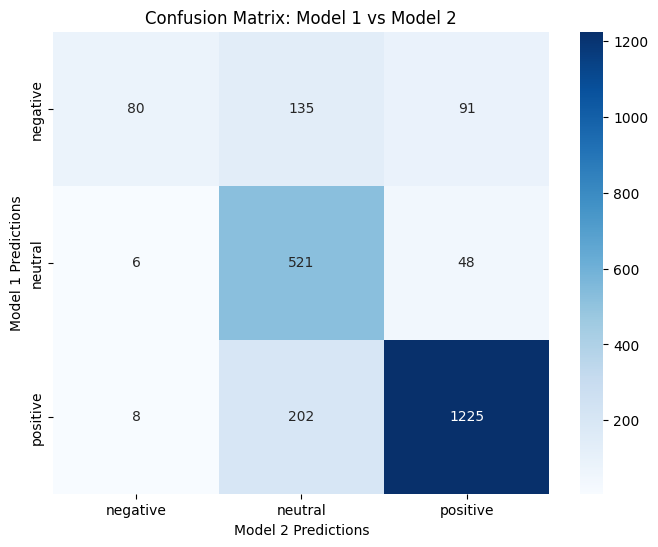

In [21]:
# Confusing matrix
confusion_matrix_both_models = pd.crosstab(all_post_comments_df['Sentiment.Model 1'], all_post_comments_df['Sentiment.Model 2'], rownames=['Model 1'], colnames=['Model 2'])

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_both_models, annot=True, cmap='Blues', fmt='d', cbar=True)
plt.title('Confusion Matrix: Model 1 vs Model 2')
plt.xlabel('Model 2 Predictions')
plt.ylabel('Model 1 Predictions')
plt.show()

In [22]:
confusion_matrix_both_models

Model 2,negative,neutral,positive
Model 1,,,
negative,80,135,91
neutral,6,521,48
positive,8,202,1225


emojiis

In [23]:
# Extracting emojis from each comment
def extract_emojis(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               "]+", flags=re.UNICODE)
    return emoji_pattern.findall(text)


all_post_comments_df['Emojis'] = all_post_comments_df['Comment'].astype(str).apply(extract_emojis)

# Creating a list of all emojis
all_emojis = all_post_comments_df['Emojis'].explode().dropna().unique()

# Creating a DataFrame with unique emojis
emojis_df = pd.DataFrame(all_emojis, columns=['Emoji'])

# Step 1: Convert emojis to sets to get unique emojis
emojis_df['Unique_Emojis'] = emojis_df['Emoji'].apply(lambda x: set(x))

# Step 2: Flatten the sets to create a list of unique emojis
unique_emojis = [emoji for emojis_set in emojis_df['Unique_Emojis'] for emoji in emojis_set]

# Step 3: Count the occurrence of each unique emoji
emoji_counts = {}
for emoji in unique_emojis:
    if emoji in emoji_counts:
        emoji_counts[emoji] += 1
    else:
        emoji_counts[emoji] = 1

# Step 4: Create a DataFrame for the summary table
summary_emoji_df = pd.DataFrame(list(emoji_counts.items()), columns=['Emoji', 'Count'])
summary_emoji_df = summary_emoji_df.sort_values(by='Count', ascending = False)
summary_emoji_df.reset_index(drop=True, inplace=True)
summary_emoji_df.index += 1
summary_emoji_df = summary_emoji_df[:10]

In [24]:
# Define emoji2description function
def emoji2description(emoji_char):
    try:
        return emoji.demojize(emoji_char)
    except AttributeError:
        return "No description available"

# Add 'Meaning' column
summary_emoji_df['Meaning'] = summary_emoji_df['Emoji'].apply(emoji2description)
summary_emoji_df

,Emoji,Count,Meaning
1,😍,75,No description available
2,🔥,68,No description available
3,🙌,32,No description available
4,👍,22,No description available
5,👏,22,No description available
6,👌,21,No description available
7,😭,20,No description available
8,😂,19,No description available
9,🏻,19,No description available
10,🏼,13,No description available


wordcloud

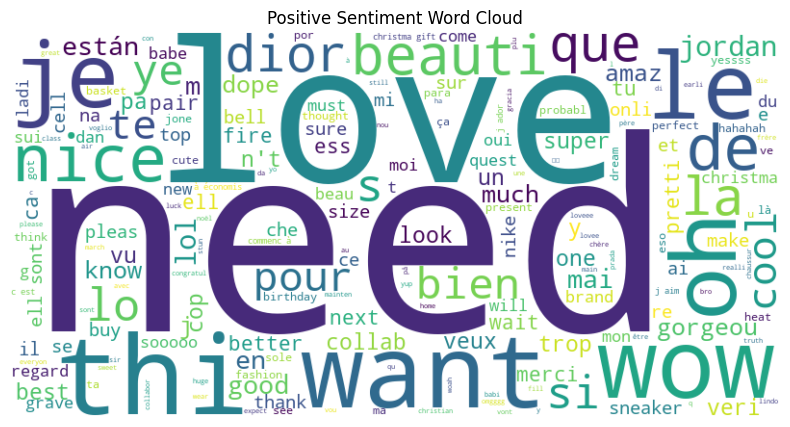

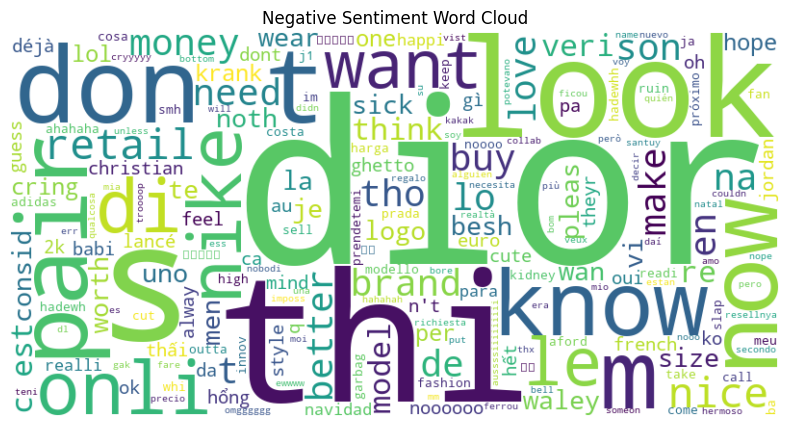

In [25]:
# Function to perform stemming
def stem_text(text):
    ps = PorterStemmer()
    words = word_tokenize(text)
    stemmed_words = [ps.stem(word) for word in words]
    return ' '.join(stemmed_words)

#  positive sentiment
positive_comments = all_post_comments_df[all_post_comments_df['Sentiment.Model 1'] == 'positive']['Cleaned Comment'].tolist()

#  negative sentiment
negative_comments = all_post_comments_df[all_post_comments_df['Sentiment.Model 1'] == 'negative']['Cleaned Comment'].tolist()

# Join positive and negative comments 
positive_text = ' '.join(positive_comments)
negative_text = ' '.join(negative_comments)

#  stemming
positive_text_stemmed = stem_text(positive_text)
negative_text_stemmed = stem_text(negative_text)

#  Word Cloud for Positive Sentiment
positive_wordcloud = WordCloud(width = 800, height = 400, background_color ='white').generate(positive_text_stemmed)

#  Word Cloud for Negative Sentiment
negative_wordcloud = WordCloud(width = 800, height = 400, background_color ='white').generate(negative_text_stemmed)

# Plot Positive Sentiment Word Cloud
plt.figure(figsize = (10, 5))
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.title('Positive Sentiment Word Cloud')
plt.axis('off')
plt.show()

# Plot Negative Sentiment Word Cloud
plt.figure(figsize = (10, 5))
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.title('Negative Sentiment Word Cloud')
plt.axis('off')
plt.show()